In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2



%matplotlib inline

In [2]:
train = loadmat("Q3_Train.mat")["Train"]
test = loadmat("Q3_Test.mat")["X"]

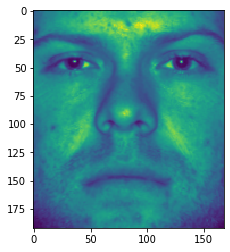

In [3]:
plt.figure()
plt.imshow(train[:,0].reshape(168,192).T)

In [4]:
m,n = train.shape
lib = np.zeros((120,n))
norms = np.zeros((1,n))
for i in range(n):
    img = train[:,i].reshape(168,192).T
    v = cv2.resize(img, dsize=(10, 12), interpolation=cv2.INTER_LANCZOS4).flatten()
    norm = np.linalg.norm(v)
    v = v/norm
    norms[0,i] = norm
    lib[:,i] = v
    
test_reshaped = np.zeros((120,4))
for i in range(4):
    img = test[:,i].reshape(168,192).T
    v = cv2.resize(img, dsize=(10, 12), interpolation=cv2.INTER_LANCZOS4).flatten()
    test_reshaped[:,i] = v

In [5]:
lib.shape

(120, 600)

In [6]:
import cvxpy as cp

def l1dantzig_pdLP(A, y, eps, verbose=True):
    '''Solves min_x ||x||_1 st --eps <= A.T@Ax - b <= eps via CVXPY
    Replaces l1dantzig_pd.m
    Unlike the MATLAB it replaces, it only takes matrix A
    Solving as an LP via GLPK
    '''
    assert eps >= 0
    m, n = A.shape
    x = cp.Variable(n)
    u = cp.Variable(n, nonneg=True)
    objective = cp.Minimize(cp.sum(u))
    constraints = [-A.T@(A@x - y)-eps <= 0,
                   A.T@(A@x - y)-eps <= 0,
                   x <= u,
                   -x-u <= 0]
    prob = cp.Problem(objective, constraints)
    # When we have no risk of complex numbers, ECOS > SCS
    result = prob.solve(solver='GLPK', verbose=verbose)
    return x.value

In [8]:
test_reshaped.shape

(120, 4)

In [15]:

s = cp.Variable((600,1))
objective = cp.Minimize(cp.normNuc(s))
constraints = [np.sum(np.linalg.norm(lib@s-test_reshaped[:,0].reshape(120,1)))<=1]
prob = cp.Problem(objective, constraints)
result = prob.solve(solver='SCS', verbose=True)

/home/jfftilton/anaconda3/envs/omsa/lib/python3.7/site-packages/cvxpy/expressions/expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


ValueError: Incompatible dimensions (120, 1) (120, 1)

In [13]:
res = np.zeros((600,4))
for i in range(4):
    s = l1dantzig_pdLP(lib, test_reshaped[:,i], eps=1, verbose=True)
    res[:,i] = s

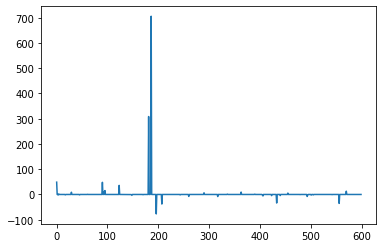

In [12]:
fig, ax = plt.subplots()
ax.plot(s)

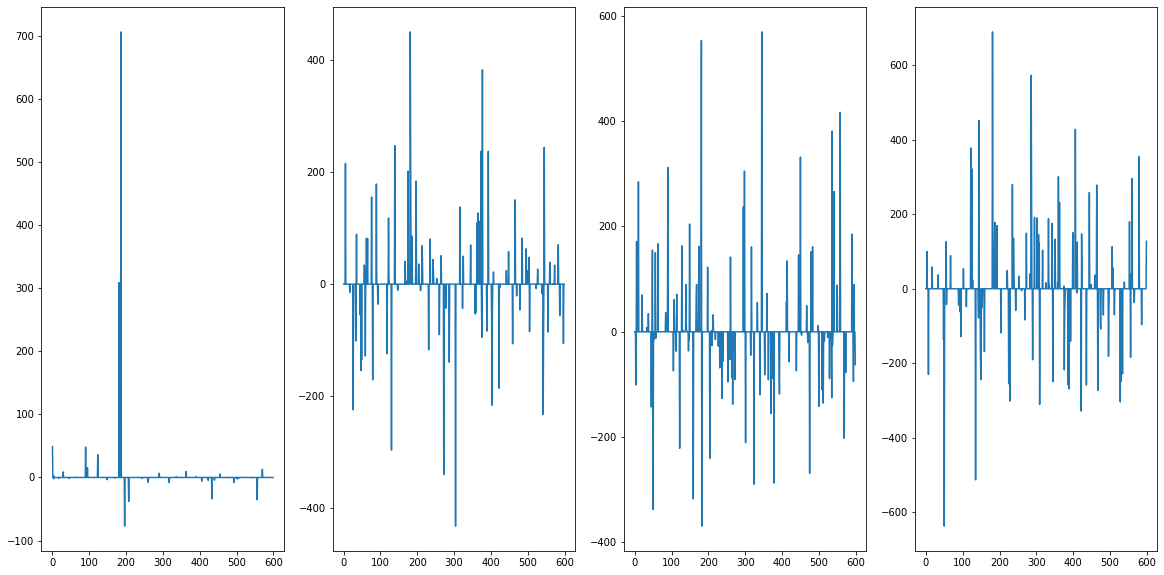

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(20,10))
images = []
for i in range(4):
    ax[i].plot(res[:,i])
    

In [15]:
t = train[:,:30]@((s.reshape((1,600)) / norms)[:,:30]).T
t.shape

(32256, 1)

In [17]:
test[:,0] - t

array([[57.77208623, 60.77208623, 59.77208623, ..., 16.77208623,
        16.77208623, 16.77208623],
       [58.72443364, 61.72443364, 60.72443364, ..., 17.72443364,
        17.72443364, 17.72443364],
       [58.73863256, 61.73863256, 60.73863256, ..., 17.73863256,
        17.73863256, 17.73863256],
       ...,
       [50.93406074, 53.93406074, 52.93406074, ...,  9.93406074,
         9.93406074,  9.93406074],
       [50.69491119, 53.69491119, 52.69491119, ...,  9.69491119,
         9.69491119,  9.69491119],
       [50.63334894, 53.63334894, 52.63334894, ...,  9.63334894,
         9.63334894,  9.63334894]])